## Machine Learning 2 for Masters Students
# Topic: Collaborative filtering vs. Content-based filtering
### Group Members: Nurbek Bektursyn, Asset Kabdula
### Date: 12.03.2024
_____________________________________


## Section 1: Introduction
- What problem does it address? <br/> <br/> 
The book recommdender system that uses both content-based filtering and collaborative filtering aims to solve a major problem in machine learning: the challenge of personalized suggestion. With an ever-increasing number of books available online and offline, people often find it difficult to decide what to read next. Therefore, our book recommder system recommends books that users are likely to appreciate based on their previous tastes and actions. 
<br/> <br/> 
- What is the intuition? <br/> <br/> 
**Popularity filtering (Baseline model):**  handles the "cold start" issue for new users for whom the system does not yet have enough data to offer tailored suggestions. _Intuition:_ highly rated by a big number of people are more likely to be enjoyed by others. This method implies that there is intrinsic value in what is popular, making such products potentially appealing to a large audience, including users with limited information about their tastes. <br/> <br/> 
**Content-based filtering:** handles the problem of suggestion by looking at the objects (books) themselves. It suggests books by assessing their content (genres, authors, language, and topics) and matching it to the user's previous choices. _Intuition:_ If a user like a book, they are more likely to appreciate subsequent books with similar content.
<br/> <br/> 
**Collaborative filtering:** handles the issue of personalized suggestions by using a community of users' interests and actions. It is assumed that if users A and B have previously rated books similarly, then books loved by user A but not yet viewed by user B are likely to be of interest to user B. _Intuition:_ "wisdom of crowds" principle, which states that aggregating preferences across users might aid in the discovery of new preferences for each individual user.

<p align="center">
  <img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExd2FrYjVzanczMjNyOWVkYm5wYnBiejIwenZqd3k5ZTg4N3Y1MGV1ayZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/3orieYVZvX5iOI4nu0/giphy.gif" width="30%" alt="Alt Text">
</p>


## Section 2: Preliminaries

Open Your Terminal or Command Prompt

Create a New Environment: 
conda create --name nlp python=3.12.2

Activate the New Environment
conda activate nlp

Install Required Packages
conda install pandas numpy matplotlib scikit-learn nltk scipy

In [1]:
# Importing necessary libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random


# Importing scikit-learn utilities for calculating cosine similarity and splitting datasets
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# NLP (Natural Language Processing) tools for text preprocessing
import nltk # the natural langauage toolkit, open-source NLP
from nltk.corpus import stopwords # To remove stopwords from text data
from sklearn.feature_extraction.text import TfidfVectorizer # To convert text to TF-IDF vectors
from nltk.tokenize import word_tokenize # For tokenizing strings into words
from nltk.stem import WordNetLemmatizer, PorterStemmer # For stemming and lemmatization of words
import string # For handling string operations

# Downloading necessary NLTK datasets for stopwords, wordnet, and tokenizers
nltk.download('stopwords') # stopwords are common words that carry less meaning than keywords, usually removed from text
nltk.download('wordnet') # wordnet is a lexical database of English words, used for text analysis
nltk.download('punkt') # Punkt Tokenizer Models for tokenizing text documents

# Importing libraries for handling sparse matrices and statistical correlations
import scipy
from scipy.stats import spearmanr
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load book and rating data from CSV files into Pandas DataFrames
books= pd.read_csv('../data/books.csv')
ratings = pd.read_csv('../data/ratings.csv')

In [3]:
# Clean the books DataFrame by removing rows with missing 'original_title' values and selecting relevant columns
books.dropna(subset="original_title", inplace=True)
books = books.loc[:,['book_id', 'original_title','authors','average_rating']]
books.head(10)

,book_id,original_title,authors,average_rating
0,1,The Hunger Games,Suzanne Collins,4.34
1,2,Harry Potter and the Philosopher's Stone,"J.K. Rowling, Mary GrandPré",4.44
2,3,Twilight,Stephenie Meyer,3.57
3,4,To Kill a Mockingbird,Harper Lee,4.25
4,5,The Great Gatsby,F. Scott Fitzgerald,3.89
5,6,The Fault in Our Stars,John Green,4.26
6,7,The Hobbit or There and Back Again,J.R.R. Tolkien,4.25
7,8,The Catcher in the Rye,J.D. Salinger,3.79
8,9,Angels & Demons,Dan Brown,3.85
9,10,Pride and Prejudice,Jane Austen,4.24


In [4]:
books.shape

(9415, 4)

In [5]:
# Calculate the number of ratings submitted by each user
ratings_per_user = ratings.groupby('user_id').size()

print(ratings_per_user)
print("The minimum number of ratings per user:", ratings_per_user.min())
print("The maximum number of ratings per user:", ratings_per_user.max())

user_id
1        117
2         65
3         91
4        134
5        100
        ... 
53420    110
53421    110
53422    130
53423     77
53424    133
Length: 53424, dtype: int64
The minimum number of ratings per user: 19
The maximum number of ratings per user: 200


In [6]:
# Calculate specified percentiles for the number of ratings per user to understand the distribution
percentiles = ratings_per_user.quantile([0.25, 0.5, 0.75, 0.9, 0.95])
percentiles

0.25     96.0
0.50    111.0
0.75    128.0
0.90    146.0
0.95    157.0
dtype: float64

In [7]:
# Merge datasets considering only users with more than 157 ratings
merged_data = pd.merge(books, ratings[ratings['user_id'].isin(ratings_per_user[ratings_per_user >= 157].index)], on='book_id', how='inner')

merged_data.head()

,book_id,original_title,authors,average_rating,user_id,rating
0,1,The Hunger Games,Suzanne Collins,4.34,7674,5
1,1,The Hunger Games,Suzanne Collins,4.34,7857,3
2,1,The Hunger Games,Suzanne Collins,4.34,2469,4
3,1,The Hunger Games,Suzanne Collins,4.34,8146,5
4,1,The Hunger Games,Suzanne Collins,4.34,1585,4


In [8]:
merged_data.shape

(449423, 6)

In [9]:
# Split the 'merged_data' DataFrame into training and test sets
train, test = train_test_split(merged_data,
                                   stratify=merged_data['user_id'], 
                                   test_size=0.50,
                                   random_state=42)
print(len(train))
print(len(test))

224711
224712


In [10]:
#Indexing by user_id to speed up the searches during evaluation
data_indexed = merged_data.sort_values(by='user_id').set_index('user_id')
train_indexed = train.sort_values(by='user_id').set_index('user_id')
test_indexed = test.sort_values(by='user_id').set_index('user_id')
data_indexed

,book_id,original_title,authors,average_rating,rating
user_id,,,,,
35,178,The Bell Jar,Sylvia Plath,3.98,3
35,186,The Other Boleyn Girl,Philippa Gregory,4.04,3
35,407,Bel Canto,Ann Patchett,3.92,3
35,451,Northanger Abbey,"Jane Austen, Alfred MacAdam",3.80,3
35,4473,Brick Lane,Monica Ali,3.38,3
...,...,...,...,...,...
53366,12,Divergent,Veronica Roth,4.24,4
53366,525,Pandemonium,Lauren Oliver,4.07,4
53366,4424,inf,Sherrilyn Kenyon,4.04,5


In [11]:
def get_items_interacted(user_id, merged_data):
    """
    Retrieves the set of items (book_ids) that a given user has interacted with.

    This function identifies and returns all unique book IDs that a specific user has interacted with.
    It is essential for ensuring that the recommendations made to the user do not include items
    the user has already interacted with.

    Parameters:
        user_id (int): The ID of the user for whom to retrieve interacted items.
        merged_data (pd.DataFrame): The DataFrame containing user interactions with books.
    
    Returns:
        set: A set of book IDs that the user has interacted with.
    """
    interacted_items = merged_data.loc[user_id]['book_id']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [12]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100
class ModelEvaluator:
    
    def get_not_interacted_items_sample(self, user_id, sample_size, seed=42):
        """
        Generates a sample of non-interacted item IDs for a given user.
        
        Parameters:
        - user_id: int or str, identifier for the user
        - sample_size: int, size of the sample to generate
        - seed: int, seed for the random number generator for reproducibility
        
        Returns:
        - set, a set of non-interacted item IDs sampled randomly
        """
        # Calculate a sample of non-interacted items for a user
        interacted_items = get_items_interacted(user_id, data_indexed)
        all_items = set(books['book_id']) # All available book IDs from the dataset
        non_interacted_items = all_items - interacted_items # Determine non-interacted items
        random.seed(seed) # Seed for reproducibility
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)  # Random sample of non-interacted items
        return set(non_interacted_items_sample)
    
    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        """
        Verifies if a specific item ID is within the top-N items of a recommendation list.
        
        Parameters:
        - item_id: int or str, the item ID to verify
        - recommended_items: list, a list of recommended item IDs
        - topn: int, the number of top items to check against
        
        Returns:
        - tuple (hit, index): hit is 1 if the item is within top-N, 0 otherwise; index is the item's index in the list or -1 if not found
        """
        # Check if the interacted item is among the top-N recommended items
        try:
            index = next(i for i, c in enumerate(recommended_items) if c ==  item_id)
        except:
            index = -1 # Item not found among the top recommendation
        hit = int(index in range(0, topn)) # Check if index is within the top-N
        return hit, index
    
    def evaluate_model_for_user(self, model, user_id):
        """
        Evaluates the model for a specific user by computing recall at different ranks.
        
        Parameters:
        - model: the model to evaluate
        - user_id: int or str, the user identifier
        
        Returns:
        - dict, metrics including hits@5, hits@10, interacted count, recall@5, and recall@10
        """
        # Evaluate model for a specific user, calculating recall at 5 and 10
        interacted_values_testset = test_indexed.loc[user_id] # Get user's data from test set
        # Determine if there are multiple interactions or just one
        if type(interacted_values_testset['book_id']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['book_id'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['book_id'])])  
        # Count of interacted items in test set
        interacted_items_count_testset = len(person_interacted_items_testset)
        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(user_id, 
                                               items_to_ignore=get_items_interacted(user_id, 
                                                                                    train_indexed), 
                                               topn=1000)

        hits_at_5_count = 0
        hits_at_10_count = 0
         # Loop through each interacted item in the test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(user_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, 
                                                                          seed=item_id%(2**32))
            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['book_id'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['book_id'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
        
        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        # Compile metrics for the user
        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics
    
    def evaluate_model(self, model):
        """
        Evaluates a model across all users in the test set.
        
        Parameters:
        - model: the model to be evaluated
        
        Returns:
        - tuple, containing global metrics and a DataFrame of detailed results per user
        """
        # Evaluate the model across all users in the test set
        people_metrics = []
        for idx, user_id in enumerate(list(test_indexed.index.unique().values)):
            
            person_metrics = self.evaluate_model_for_user(model, user_id)  
            person_metrics['_person_id'] = user_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)
        # Aggregate results
        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

## Section 3: Popularity Filtering (Baseline model)
Same recommendtion for every user (except for removing the book that the user already read).

In [13]:
#Compute the most popular items
item_popularity_df = books.sort_values(by='average_rating', ascending=False).reset_index(drop=True)
item_popularity_df.head(10)

,book_id,original_title,authors,average_rating
0,3628,The Complete Calvin and Hobbes,Bill Watterson,4.82
1,862,Words of Radiance,Brandon Sanderson,4.77
2,8854,Mark of the Lion Trilogy,Francine Rivers,4.76
3,4483,It's a Magical World: A Calvin and Hobbes Coll...,Bill Watterson,4.75
4,6361,There's Treasure Everywhere: A Calvin and Hobb...,Bill Watterson,4.74
5,422,Complete Harry Potter Boxed Set,J.K. Rowling,4.74
6,6920,The Indispensable Calvin and Hobbes: A Calvin ...,Bill Watterson,4.73
7,3753,"Harry Potter Collection (Harry Potter, #1-6)",J.K. Rowling,4.73
8,6590,The Authoritative Calvin and Hobbes,Bill Watterson,4.73
9,1308,A Court of Mist and Fury,Sarah J. Maas,4.72


In [14]:
class PopularityRecommender:
    """
    A recommender system that suggests popular items based on average ratings.
    
    Attributes:
        MODEL_NAME (str): The name of the model.
        popularity_df (DataFrame): A dataframe containing items with their popularity metrics.
        items_df (DataFrame, optional): A dataframe containing additional item details.
    """
    
    MODEL_NAME = 'Popularity'
    def __init__(self, popularity_df, items_df=None):
        """
        Initializes the PopularityRecommender with necessary data.
        
        Parameters:
            popularity_df (DataFrame): A dataframe containing the popularity data of the items.
            items_df (DataFrame, optional): A dataframe containing detailed information about the items.
        """
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        """
        Returns the name of the model.
        
        Returns:
            str: The name of the model.
        """
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """
        Recommends items that are not in the list of items to ignore, based on popularity.
        
        Parameters:
            user_id (int or str): The user ID for whom the recommendations are to be made.
            items_to_ignore (list, optional): A list of item IDs that should be ignored in the recommendations.
            topn (int, optional): The number of recommendations to return.
            verbose (bool, optional): If True, returns additional details about the items.
        
        Returns:
            DataFrame: The top N recommended items with their details based on the mode selected.
        
        Raises:
            Exception: If 'items_df' is not provided when verbose mode is enabled.
        """
        # Recommend the most popular items that the user hasn't seen yet.
        recommendations_df = self.popularity_df[~self.popularity_df['book_id'].isin(items_to_ignore)] \
                               .sort_values('average_rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'book_id', 
                                                          right_on = 'book_id')[['average_rating', 'book_id', 'original_title', 'authors']]


        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, books)

In [15]:
print('Evaluating Popularity recommendation model...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % pop_global_metrics)
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model...
2728 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.058728505820783934, 'recall@10': 0.10017266545622841}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
792,7,10,99,0.070707,0.101010,12381
1851,18,22,99,0.181818,0.222222,30944
2687,8,15,98,0.081633,0.153061,52036
1263,8,9,98,0.081633,0.091837,19729
824,7,10,98,0.071429,0.102041,12874
2456,10,11,98,0.102041,0.112245,45554
2147,7,12,97,0.072165,0.123711,37834
595,4,7,97,0.041237,0.072165,9668
600,3,5,97,0.030928,0.051546,9731
1023,6,11,97,0.061856,0.113402,15604


It achieved the Recall@5 of 0.0587, which means that about 5% of interacted items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And Recall@10 was even higher (10%), as expected.

## Section 4: Show-case - Content-based filtering



<p align="center">
  <img src="https://miro.medium.com/max/828/1*1b-yMSGZ1HfxvHiJCiPV7Q.png" width="20%" alt="Alt Text">
</p>

In [16]:
class PreprocessingPipeline:
    """
    A preprocessing pipeline class for cleaning and normalizing text data

    Attributes:
        stop_words (set of str): A set containing stop words to be removed from the text.
        lemmatizer (WordNetLemmatizer): An NLTK lemmatizer for reducing words to their lemma.
        punctuation (str): A string of punctuation characters to be removed from the text.
    """
    def __init__(self):
        """
        Initializes the PreprocessingPipeline by setting up the stop words, lemmatizer, and punctuation.
        """
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()
        self.punctuation = string.punctuation

    def tokenize_and_preprocess(self, text):
        """
        Parameters:
            text (str): The text to preprocess.

        Returns:
            list of str: A list of lemmatized words after preprocessing.
        """
        
        tokens = word_tokenize(text)
        preprocessed_tokens = []
        for token in tokens:
            token = token.lower()  # Case folding
            if token in self.stop_words or not token.isalpha():
                continue  # Removing stop-words and unwanted characters
            token = self.lemmatizer.lemmatize(token)  # Lemmatizing tokens
            preprocessed_tokens.append(token)
        return preprocessed_tokens
    
preprocessing_pipeline = PreprocessingPipeline()

In [17]:
vectorizer = TfidfVectorizer(analyzer='word',
                     tokenizer=preprocessing_pipeline.tokenize_and_preprocess,
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000)
item_ids = books['book_id'].tolist()
tfidf_matrix = vectorizer.fit_transform(books['original_title'] + " " + books['authors'])
tfidf_feature_names = vectorizer.get_feature_names_out()
tfidf_matrix

<9415x247 sparse matrix of type '<class 'numpy.float64'>'
	with 13904 stored elements in Compressed Sparse Row format>

In [18]:
def get_item_profile(item_id):
    """
    Retrieves the TF-IDF vector for a specified item by its ID.

    This function locates the index of the specified item using its ID and then extracts the 
    corresponding row from the TF-IDF matrix. This row (or item profile) represents the item's 
    textual features encoded as TF-IDF values, which can be used for calculating similarities 
    with other items or for making recommendations.

    Parameters:
        item_id (int): The ID of the item for which to retrieve the TF-IDF profile.

    Returns:
        scipy.sparse.csr.csr_matrix: The TF-IDF vector of the item as a sparse matrix.
    """
    # Locate the index of the specified item_id in the list of all item IDs
    idx = item_ids.index(item_id)
    # Extract the TF-IDF vector for the specified item using its index
    item_profile = tfidf_matrix[idx:idx+1]
    
    return item_profile

def get_item_profiles(ids):
    """
    Retrieves and aggregates the TF-IDF profiles for a list of item IDs.

    This function uses a list comprehension to fetch the individual TF-IDF vectors 
    (item profiles) for each item ID provided in the list 'ids'. It then combines 
    these vectors into a single sparse matrix using vertical stacking (vstack), 
    which is useful for performing bulk operations like calculating similarities 
    or generating recommendations for multiple items at once.

    Parameters:
        ids (list of int): A list of item IDs for which to retrieve the TF-IDF profiles.

    Returns:
        scipy.sparse.csr.csr_matrix: A combined sparse matrix containing the TF-IDF vectors
                                     for all specified items.
    """
    # Generate a list of item profiles using a list comprehension
    item_profiles_list = [get_item_profile(x) for x in ids]
    # Vertically stack the list of individual item profiles into one sparse matrix
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    
    return item_profiles

def build_users_profile(user_id, interactions_indexed_df):
    """
    Builds a normalized user profile based on their interactions and ratings.

    This function calculates the weighted average of item profiles associated with the books
    a user has interacted with, using the user's ratings as weights for averaging. The result
    is then normalized to ensure uniformity in scale.

    Parameters:
    user_id (int): The unique identifier for the user.
    interactions_indexed_df (DataFrame): A pandas DataFrame indexed by user_id that contains 
                                         the book interactions along with user ratings.

    Returns:
    numpy.ndarray: The normalized weighted average profile for the specified user.
    """
    interactions_person_df = interactions_indexed_df.loc[user_id]
    user_item_profiles = get_item_profiles(interactions_person_df['book_id'])
    # Use the ratings as weights
    user_item_ratings = np.array(interactions_person_df['rating']).reshape(-1,1)
    # Calculate the weighted average of item profiles, using the ratings as weights.
    user_item_ratings_weighted_avg = np.sum(user_item_profiles.multiply(user_item_ratings), axis=0) / np.sum(user_item_ratings)
    # Normalize the weighted average to ensure a uniform scale.
    user_profile_norm = sklearn.preprocessing.normalize(np.asarray(user_item_ratings_weighted_avg))
    
    return user_profile_norm

def build_users_profiles(train):
    """
    Constructs user profiles for all users in the training dataset who have interacted with books.

    This function iterates over unique user IDs in a training dataset, building a profile for each
    user by aggregating their interactions and ratings with books. Each user's profile is created
    using the `build_users_profile` function, which calculates a normalized weighted average
    of item profiles based on the books the user has interacted with and their corresponding ratings.

    The training dataset is filtered to only include interactions with books listed in a separate 
    books dataset.

    Returns:
    dict: A dictionary mapping user IDs to their corresponding normalized weighted average profiles.
    """
    interactions_indexed_df = train[train['book_id'] \
                                                   .isin(books['book_id'])].set_index('user_id')
    user_profiles = {}
    for user_id in interactions_indexed_df.index.unique():
        user_profiles[user_id] = build_users_profile(user_id, interactions_indexed_df)
    
    return user_profiles

In [20]:
user_profiles = build_users_profiles(train)
len(user_profiles)

2729

An example of a user profile.

In [21]:
id = 35
myprofile = user_profiles[id]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[id].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 247)


,token,relevance
0,smith,0.291435
1,william,0.269649
2,ann,0.247159
3,jane,0.226299
4,anne,0.210372
5,john,0.203345
6,brook,0.196299
7,white,0.184692
8,david,0.173840
9,james,0.166999


In [22]:
class ContentBasedRecommender:
    """
    A content-based recommender system that suggests items based on the similarity between item profiles and a user's profile.
    
    Attributes:
        MODEL_NAME (str): The name of the recommendation model.
        items_df (DataFrame): A DataFrame containing detailed information about the items.
    """
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        """
        Initializes the ContentBasedRecommender with item details.
        
        Parameters:
            items_df (DataFrame, optional): A DataFrame containing details about each item.
        """
        self.item_ids = item_ids    #
        self.items_df = items_df    #
        # self.user_profiles 
        # self.item_profiles
        
    def get_model_name(self):
        """
        Returns the name of the recommendation model.
        
        """
        return self.MODEL_NAME
    
    def _get_similar_items_to_user_profile(self, user_id, topn=1000):    # all the parameters should go in here  tfidf_matrix
        """
        Computes the cosine similarity between a specific user's profile and all item profiles, returning the top N similar items.
        
        Parameters:
            user_id (int or str): The user identifier.
            topn (int): Number of top similar items to return.
        
        Returns:
            list of tuples: A list of tuples, each containing an item ID and its similarity score.
        """
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[user_id], tfidf_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """
        Generates a list of recommended items for a user, excluding items the user has already interacted with.
        
        Parameters:
            user_id (int or str): The user identifier.
            items_to_ignore (list of int/str, optional): List of item IDs to ignore in the recommendations.
            topn (int, optional): The number of recommendations to return.
            verbose (bool, optional): If True, includes detailed information about each item in the recommendations.
        
        Returns:
            DataFrame: A DataFrame containing the recommended items along with their recommendation strength.
        
        Raises:
            Exception: If 'items_df' is not provided when verbose mode is enabled.
        """
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['book_id', 'recStrength']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['average_rating', 'book_id', 'original_title', 'authors']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(books)

In [23]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
2728 users processed

Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.20806187475524227, 'recall@10': 0.2816672006835416}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
792,7,16,99,0.070707,0.161616,12381
1851,19,36,99,0.191919,0.363636,30944
2687,23,31,98,0.234694,0.316327,52036
1263,14,21,98,0.142857,0.214286,19729
824,8,14,98,0.081633,0.142857,12874
2456,13,20,98,0.132653,0.204082,45554
2147,7,12,97,0.072165,0.123711,37834
595,5,15,97,0.051546,0.154639,9668
600,23,34,97,0.237113,0.350515,9731
1023,16,22,97,0.164948,0.226804,15604


With personalized recommendations of content-based filtering model, we have a Recall@5 of 0.208, which means that about 20% of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items). And Recall@10 was 0.261 (26%). 

## Show-case - Collaborative filtering

<p align="center">
  <img src="https://cdn-images-1.medium.com/max/1000/0*gJ8CeGoD9IAHzSmb.png" width="30%" alt="Alt Text">
</p>

In [37]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = train.pivot(index='user_id', 
                                                          columns='book_id', 
                                                          values='average_rating').fillna(0)

users_items_pivot_matrix_df.head(10)

book_id,1,2,3,4,5,6,7,8,9,10,...,9990,9991,9992,9993,9994,9995,9997,9998,9999,10000
user_id,,,,,,,,,,,,,,,,,,,,,
35,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75,4.34,0.00,0.00,0.00,0.0,0.0,0.00,3.79,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143,4.34,0.00,3.57,0.00,0.0,0.0,0.00,0.00,3.85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
145,0.00,0.00,3.57,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,0.00,4.44,0.00,0.00,0.0,0.0,0.00,0.00,3.85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
178,4.34,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202,0.00,0.00,3.57,0.00,0.0,0.0,4.25,3.79,3.85,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
215,0.00,0.00,0.00,0.00,0.0,0.0,4.25,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
230,0.00,0.00,0.00,4.25,0.0,0.0,0.00,0.00,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# load the data: user_id, book_id, rating
#matrix = sparse matrix with zeros only
#for row in data:
#    matrix[user_id, book_id] =  rating

In [39]:
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()  # transform into a sparse matrix
users_items_pivot_matrix[:10]

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [4.34, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [4.34, 0.  , 3.57, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [40]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[35, 75, 143, 145, 173, 178, 202, 215, 230, 247]

In [41]:
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<2729x8578 sparse matrix of type '<class 'numpy.float64'>'
	with 224711 stored elements in Compressed Sparse Row format>

In [42]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)   #Partial singular value decomposition of a sparse matrix. 
                                            #Compute the largest or smallest k singular values and corresponding singular vectors of a sparse matrix

In [43]:
U.shape    

(2729, 15)

In [44]:
Vt.shape

(15, 8578)

In [45]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [46]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 1.68126704e-01,  3.73080326e-01,  7.13916007e-01, ...,
         1.40045007e-03,  3.80923788e-03, -5.22281137e-04],
       [ 4.98148731e+00,  8.57049256e-01,  9.44652284e-01, ...,
        -1.78879747e-03,  3.15692209e-02, -2.37913185e-03],
       [ 3.65554079e+00,  8.29523199e-01,  1.12375004e+00, ...,
        -5.85387280e-04,  1.43820712e-02, -6.68687932e-03],
       ...,
       [ 4.08167404e-01,  8.72931119e-01, -4.79548584e-01, ...,
         1.06585888e-03,  5.44602676e-03,  1.83438305e-02],
       [ 2.70803416e+00,  8.27769404e-01,  1.18463564e+00, ...,
        -2.88675268e-03, -5.24352514e-03,  2.62938433e-02],
       [-9.96656239e-01,  1.88038289e+00,  1.41898875e+00, ...,
         4.12717504e-03, -3.76672125e-03,  3.12909869e-03]])

In [47]:
# Normalize the predicted ratings for all users to a range of 0 to 1. This scaling helps in managing different scales 
# of raw ratings data by bringing them to a uniform scale. The minimum rating value becomes 0, and the maximum rating value becomes 1.
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [48]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,35,75,143,145,173,178,202,215,230,247,...,53145,53165,53173,53245,53279,53281,53292,53293,53318,53366
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.319792,0.880142,0.725781,0.542438,0.308014,0.676605,0.318696,0.207508,0.179464,0.223074,...,0.814943,0.392765,0.321624,0.229526,0.398921,0.428731,0.248550,0.347736,0.615476,0.184193
2,0.343651,0.399993,0.396788,0.141346,0.717227,0.335033,0.615235,0.480683,0.329444,0.462868,...,0.716402,0.457841,0.274907,0.314013,0.278259,0.430628,0.332493,0.401842,0.396584,0.519125
3,0.383330,0.410191,0.431041,0.319546,0.381422,0.338088,0.377241,0.377506,0.298311,0.276645,...,0.544426,0.524592,0.308424,0.319927,0.332474,0.410191,0.472912,0.244392,0.438129,0.465411
4,0.304516,0.348477,0.274575,0.429150,0.418609,0.279213,0.589769,0.465026,0.489785,0.595688,...,0.453546,0.466856,0.442649,0.395112,0.317190,0.534497,0.468208,0.290402,0.408185,0.529889
5,0.296541,0.435863,0.372541,0.465252,0.437536,0.343002,0.476124,0.444381,0.434190,0.457027,...,0.407951,0.377026,0.340480,0.318417,0.388666,0.507850,0.453101,0.239515,0.366030,0.427943
6,0.312493,0.381530,0.421182,0.288339,0.588221,0.372164,0.310786,0.300384,0.451602,0.289183,...,0.319311,0.518667,0.295601,0.379540,0.428033,0.340980,0.455691,0.278449,0.358576,0.559451
7,0.327384,0.362367,0.402113,0.274259,0.444386,0.326235,0.480839,0.535896,0.347800,0.324260,...,0.496192,0.369638,0.246093,0.295427,0.382038,0.382600,0.438469,0.239592,0.372114,0.400534
8,0.278512,0.397557,0.349411,0.441087,0.409655,0.317775,0.505556,0.436490,0.426586,0.503652,...,0.395672,0.392362,0.402805,0.352758,0.338758,0.506399,0.428616,0.282545,0.377733,0.443306
9,0.360703,0.413792,0.419337,0.354076,0.362830,0.317345,0.448181,0.413939,0.345953,0.347785,...,0.435695,0.392005,0.403737,0.350820,0.281673,0.457621,0.368488,0.319652,0.385420,0.305039


In [49]:
len(cf_preds_df.columns)

2729

In [50]:
class CFRecommender:
    """
    A recommender system class that implements Collaborative Filtering based on a precomputed prediction matrix.
    
    Attributes:
        MODEL_NAME (str): The name of the model, indicating the type of recommendation algorithm used.
        cf_predictions_df (DataFrame): A DataFrame containing the collaborative filtering predictions.
        items_df (DataFrame, optional): A DataFrame containing details about the items.
    """
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        """
        Initializes the CFRecommender with necessary data.
        
        Parameters:
            cf_predictions_df (DataFrame): A DataFrame containing user-item rating predictions.
            items_df (DataFrame, optional): A DataFrame containing details about each item.
        """
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df


    def get_model_name(self):
        """
        Returns the name of the recommendation model.
        """
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """
        Generates a list of recommended items for a user based on collaborative filtering predictions, excluding items the user has already interacted with.
        
        Parameters:
            user_id (int or str): The user identifier.
            items_to_ignore (list of int/str, optional): List of item IDs to ignore in the recommendations.
            topn (int, optional): The number of recommendations to return.
            verbose (bool, optional): If True, includes detailed information about each recommended item.
        
        Returns:
            DataFrame: A DataFrame containing the recommended items along with their recommendation strengths.
        
        Raises:
            Exception: If 'items_df' is not provided when verbose mode is enabled.
        """
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['book_id'].isin(items_to_ignore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'book_id', 
                                                          right_on = 'book_id')[['recStrength', 'book_id',  'original_title', 'authors']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, books)

In [51]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
2728 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.6342340417957207, 'recall@10': 0.7513305920467087}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
792,82,90,99,0.828283,0.909091,12381
1851,83,92,99,0.838384,0.929293,30944
2687,76,88,98,0.775510,0.897959,52036
1263,71,84,98,0.724490,0.857143,19729
824,85,89,98,0.867347,0.908163,12874
2456,95,97,98,0.969388,0.989796,45554
2147,67,78,97,0.690722,0.804124,37834
595,53,70,97,0.546392,0.721649,9668
600,81,91,97,0.835052,0.938144,9731
1023,77,85,97,0.793814,0.876289,15604


Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got Recall@5 (63%) and Recall@10 (75%) values, much higher than Popularity model and Content-Based model.

## Section 5: Results and Analysis

In [52]:
metrics = [cb_global_metrics, pop_global_metrics, cf_global_metrics]
global_metrics_df = pd.DataFrame([pop_global_metrics, cb_global_metrics, cf_global_metrics]) \
                        .set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Popularity,0.058729,0.100173
Content-Based,0.208062,0.281667
Collaborative Filtering,0.634234,0.751331


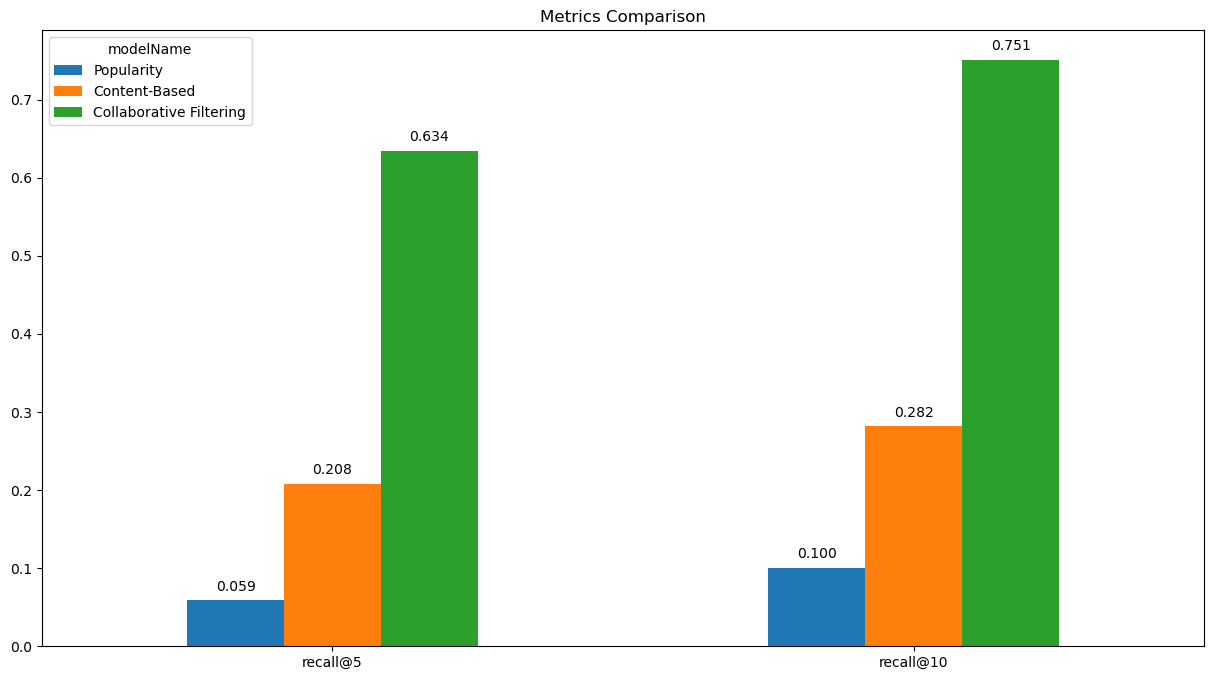

In [53]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8), title='Metrics Comparison')
# Setting x-axis labels to horizontal
plt.xticks(rotation=0)
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points')

## Section 6: Caution


Our evaluation method is based on the simplistic assumption that books that the user has not previously interacted with are irrelevant. However, it is crucial to note that this may not truly reflect reality, since the lack of engagement might be due to the user's unfamiliarity with these books instead of a true indifference.

## Section 7: Summary
Book recommender systems demonstrate the power of machine learning (ML) applications for improving user experience. In this notebook, we've looked at different Recommender Systems techniques on [goodbooks-10k](https://www.kaggle.com/datasets/zygmunt/goodbooks-10k) dataset. The Collaborative filtering tenchnique apeared to be the best compared to Popularity and Content-based filtering techniques, delivering personalized book recommendations that resonate with individual users' tastes and reading histories. However, there is still room for improvement like integrating a hubrid method (Collaborative + Content-based filtering) into the analysis or/and making the analysis more interactive, making the system more dynamic and responsive to individual needs. <br><br>
Looking ahead, incorporating these improvements promises not just to improve the accuracy and relevance of book suggestions, but also to open the way for more sophisticated, adaptive, and user-centric recommender systems. The path of refining and inventing in the field of recommender systems continues, and the incorporation of hybrid models and interactive components promises interesting future steps in making the digital reading experience more customized and engaging for readers throughout the world.

# Section 8: References and Resources
1. https://www.kaggle.com/code/niharika41298/netflix-vs-books-recommender-analysis-eda/notebook
2. https://www.kaggle.com/code/gspmoreira/recommender-systems-in-python-101#Conclusion
- In this project, we had to use ChatGPT to debug some errors encountered in our analysis, which significantly accelerated our development process of the recommender system.
- Author contributions: <br>
Nurbek: Popularity filtering & Content-based   <br>
Asset: Collaborative filtering & Top N accuracy metric

## Section 9: Review Questions
1. What is a recommender system, and why is it relevant in today's digital world?
2. Can you describe the distinction between collaborative and content-based filtering?
3. What role does popularity-based filtering play in recommender systems?
4. Describe how content-based filtering recommends items to users.
5. Describe how collaborative filtering recommends items to users.
6. What are Top-N accuracy metrics, and why are they important in evaluating recommender systems?
7. What is Spearman rank correlation coefficient? How does it work in context of book recommendation?